In [10]:
from sympy import S, symbols, printing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set_style('white')

In [11]:

# Add a column to dataframe with seconds instead of a timestamp
def timestamp_to_seconds(timestamp):
    totalseconds = 0
    timestamp2 = timestamp.split(":")
    totalseconds += (int(timestamp2[1]) + (int(timestamp2[0]) * 60))
    return totalseconds

# Runs conduction heat transfer equation
def conduction(roadtemp, shell_starting_temp, size):
    roadtemp += 273 # Kelvin
    t = 1 # seconds
    k = 0.1934 # W/mK
    T1 = shell_starting_temp + 273 # Kelvin
    if size.lower() == "small": 
        d = 0.004 # m
        A = (6542 * (10**-6)) * 0.642 # m^2
    elif size.lower() == "medium":
        d = 0.0050 # m
        A = (9346 * (10**-6)) * 0.590 # m^2
    return k*A*t*((roadtemp-T1)/d) # Return J transferred in that second

# q = mcat, q in Joules
def tempraised(q, size):
    if size.lower() == "small":
        m = 22.5 # g
    elif size.lower() == "medium":
        m = 36.944 # g
    c = 1.53 # j/g/C
    return q / (m*c) # Returns temperature raised (degrees)

# Uses result from tempraised to make a list of temps
def combine(roadtemp, seconds, start, size):
    temps = [start]
    for x in range(0, seconds):
        shelltemp = temps[x]
        temps.append(shelltemp + tempraised(conduction(roadtemp, shelltemp, size), size))
    return temps

# Returns average percent error over 2 lists
def error(theoretical, experimental):
    theoretical = np.array(theoretical)
    experimental = np.array(experimental)
    differences = (experimental - theoretical) / experimental
    differences = abs(differences)
    li = differences * 100
    li = pd.DataFrame(li)
    li.to_csv("%s.csv" % str(np.average(differences) * 100))
    return str(round(np.average(differences) * 100, 3))

def graphcsv(file):
    # Read initial file with data
    data = pd.read_csv("%s" % file)
    
    # Change timestamps to seconds
    data_secondslist = []
    for x in data["Timestamp"]:
        data_secondslist.append(timestamp_to_seconds(x))
    data["Seconds"] = data_secondslist
    size = data["Size"][0]
    startingtemp = data["Starting Temp"][0]

    # Set x and y parameters
    xdata = np.array(data["Seconds"])
    ydata = np.array(data["Temperature"])

    # Get the equation fitted to a 2nd order polynomial
    p = np.polyfit(xdata, ydata, 2) # Coefficients
    f = np.poly1d(p) # The equation

    # Format equation for display
    # Calculate new x and y
    x_new = np.linspace(xdata[0], xdata[-1], max(xdata)+1)
    y_new = f(x_new)
    x = symbols("x")
    poly = sum(S("{:6.6f}".format(v))*x**i for i, v in enumerate(p[::-1]))
    eq_latex = printing.latex(poly)

    # Get theoretical data from the x and y data 
    theoretical = combine(startingtemp, max(xdata), min(y_new), size)

    # Plot the experimental data
    p1 = sns.lineplot(xdata, ydata, color='cornflowerblue', label="Experimental")
    # Plot the best fit curve
    sns.lineplot(x_new, y_new, label="${}$".format(eq_latex), color='forestgreen')
    
    # Plot the theoretical data
    sns.lineplot(np.arange(len(theoretical)), theoretical, color='red', label="Theoretical")

    # Add text with the percent error
    p1.text(max(x_new) - 150, max(ydata) - (0.25 * (max(ydata) - min(ydata))), "Avg. % Error: " + error(theoretical, y_new), 
            horizontalalignment='left', size='medium', color='black')
    
    print(error(theoretical, y_new))
    
    plt.legend(fontsize="small")
    plt.xlabel("Time Elapsed (seconds)")
    plt.ylabel("Internal Temperature (°C)")
    plt.title("%s, %s°C" % (size, startingtemp))
    plt.tight_layout
    sns.despine()
    plt.savefig("%s" % file[:-4], dpi=600)
    plt.close()

In [13]:
data

,Seconds,Temperature,Plate,Air
0,5,28.0,53.8,37.8
1,10,28.0,NaN,NaN
2,15,28.1,NaN,NaN
3,20,28.1,NaN,NaN
4,25,28.1,NaN,NaN
...,...,...,...,...
83,420,37.8,NaN,NaN
84,425,37.6,NaN,NaN
85,430,37.0,NaN,NaN
86,435,37.1,NaN,NaN


Text(0.5, 1.0, 'Experimental vs. Theoretical Radiation')

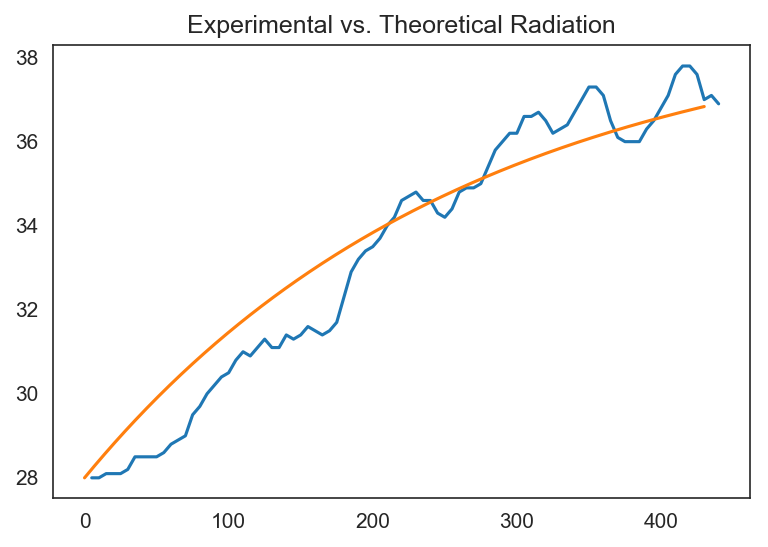

In [14]:
# -----------------------------------------------
# TESTING THE ACCURACY OF THE PROPOSED RADIATION MODEL
data = pd.read_excel("data/firstradiation.xlsx")
secs = data["Seconds"]
temps = data["Temperature"]
plt.plot(secs, temps, label = "Experimental")
plt.plot(combine(39, 430, 28, 'medium'), label = "Theoretical") # air temp was 39 about
plt.title("Experimental vs. Theoretical Radiation")
plt.show()

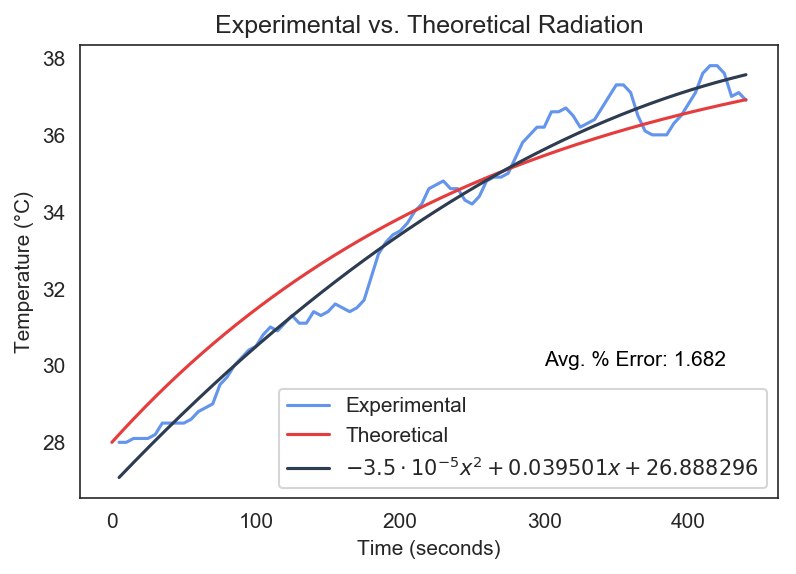

In [30]:
xdata = np.array(secs)
ydata = np.array(temps)
# Get the equation fitted to a 2nd order polynomial
p = np.polyfit(xdata, ydata, 2) # Coefficients
f = np.poly1d(p) # The equation

# Format equation for display
# Calculate new x and y
x_new = np.linspace(xdata[0], xdata[-1], max(xdata)+1)
y_new = f(x_new)
x = symbols("x")
poly = sum(S("{:6.6f}".format(v))*x**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

# Plot the experimental data
p1 = sns.lineplot(xdata, ydata, color='cornflowerblue', label="Experimental")
p1.text(300, 30, "Avg. % Error: " + error(combine(39, max(xdata), 28, 'medium'), y_new), horizontalalignment='left', size='medium', color='black')
# Plot the best fit curve
plt.plot(combine(39, max(xdata), 28, 'medium'), label = "Theoretical", color='#E53D3D')
sns.lineplot(x_new, y_new, label="${}$".format(eq_latex), color='#2D3C51')

plt.title("Experimental vs. Theoretical Radiation")

plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (°C)")

plt.savefig("./graphs/radiationaccuracy.png", dpi=600)

In [23]:
print(error(combine(39, max(xdata), 28, 'medium'), y_new))

1.682
